/Users/cindyzhou/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/cindyzhou/anaconda2/lib/python2.7/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"


Optimization terminated successfully.
         Current function value: 12.218274
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15


100%|██████████| 200000/200000 [00:44<00:00, 4536.72it/s]


Optimization terminated successfully.
         Current function value: 12.293439
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16


100%|██████████| 200000/200000 [00:43<00:00, 4606.61it/s]


Optimization terminated successfully.
         Current function value: 13.909192
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13


100%|██████████| 200000/200000 [00:43<00:00, 4599.68it/s]


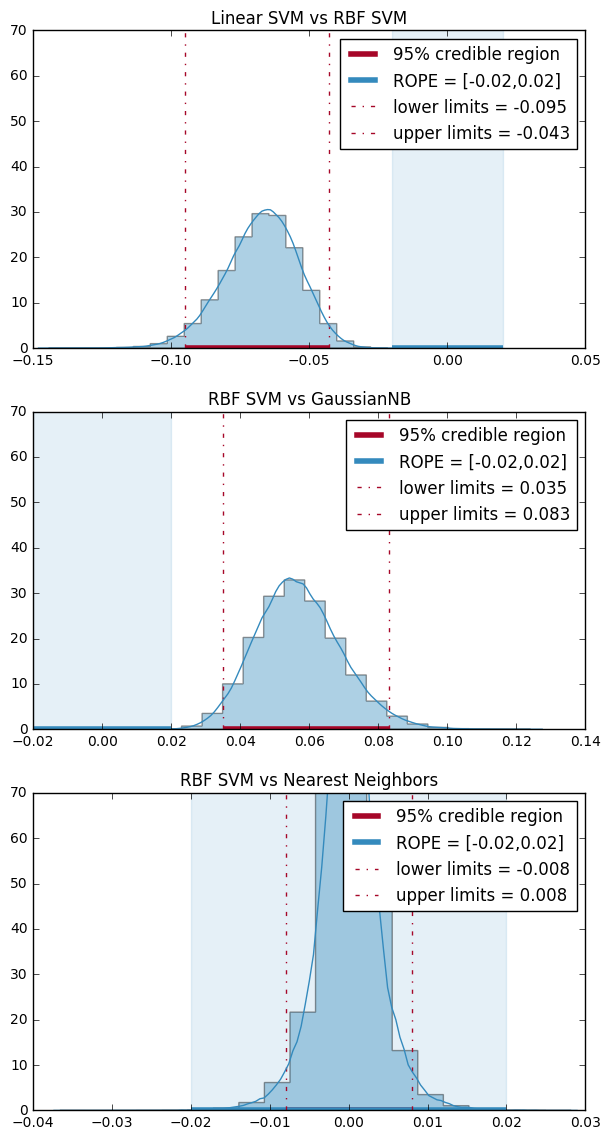

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import rankdata
import seaborn.apionly as sns
import matplotlib.patches as patches
%matplotlib inline

colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

names = ["Linear SVM", "RBF SVM", "GaussianNB","Nearest Neighbors"]

classifiers = [
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianNB(),
    KNeighborsClassifier(3)
]

X, y = make_moons(noise=0.3, random_state=0)
# rng = np.random.RandomState(2)
# X += 2 * rng.uniform(size=X.shape)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
figure = plt.figure(figsize=(6,12))

pair_list = [(0,1),(1,2),(1,3)]
for pair,i in zip(pair_list,range(3)):
    clf = classifiers[pair[0]]
    name1 = names[pair[0]]
    clf.fit(X_train,y_train)
    if hasattr(clf,"decision_function"):
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:,1]
    
    pos_score = y_score[y_test==1]
    neg_score = y_score[y_test==0]
    alldata = np.concatenate((pos_score , neg_score))
    ranked = rankdata(alldata)
    m1 = len(pos_score)
    m2 = len(neg_score)
    pos_rank = ranked[:m1]
    neg_rank = ranked[m1:]
    s = np.sum(pos_rank,axis=0)
    count = s - m1*(m1+1)/2.0

    clf = classifiers[pair[1]]
    name2 = names[pair[1]]
    clf.fit(X_train,y_train)
    if hasattr(clf,"decision_function"):
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:,1]
    pos_score = y_score[y_test==1]
    neg_score = y_score[y_test==0]
    alldata = np.concatenate((pos_score , neg_score))
    ranked = rankdata(alldata)
    pos_rank = ranked[:m1]
    neg_rank = ranked[m1:]
    s2 = np.sum(pos_rank,axis=0)
    count2 = s2 - m1*(m1+1)/2.0
   
    sample = 200000
    with pm.Model() as model:
        p = pm.Beta('p',alpha=1,beta=1)
        n = pm.Binomial('n',n=m1*m2,p=p,observed=count)
        p2 = pm.Beta('p2',alpha=1,beta=1)
        n2 = pm.Binomial('n2',n=m1*m2,p=p2,observed=count2)
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(sample, step, start=start, progressbar=True)
        
    delta = trace['p']-trace['p2']
    lower_limits = np.round(np.sort(delta)[int(0.025 * sample)],decimals=3)
    upper_limits = np.round(np.sort(delta)[int(0.975 * sample)],decimals=3)
    ax = plt.subplot(3,1,i+1)

    vlines_height = 70
    _ = ax.hlines(0.1, lower_limits, upper_limits, label="95% credible region",
               color=colors[1], linewidths=4)
    _ = ax.set_ylim(0,70)
    _ = ax.hlines(0.1, -0.02, 0.02, label='ROPE = [-0.02,0.02]',
               color=colors[0], linewidths=4)
    _ = ax.add_patch(patches.Rectangle((-0.02,0.1),0.04,70,alpha = 0.1,color=colors[9]))
    _ = ax.vlines(lower_limits,  0.1, vlines_height, label="lower limits = {0:0.3f}".format(lower_limits),
               linestyles="-.", color=colors[1], linewidths=1)
    _ = ax.vlines(upper_limits,  0.1, vlines_height, label="upper limits = {0:0.3f}".format(upper_limits),
               linestyles="-.", color=colors[1], linewidths=1)
    _ = ax.legend()
    _ = ax.set_title(name1+' vs '+name2)
    sns.distplot(delta,bins=20,color=colors[0],hist_kws={"histtype": "stepfilled"})
figure.subplots_adjust(left=.04, right=.96, bottom=.05, top=.95)